In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install interruptingcow
!pip install whois
!pip install pyquery

You should consider upgrading via the 'c:\users\adi\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\adi\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\adi\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [1]:
from tqdm import tqdm
from interruptingcow import timeout
import os
import whois
from datetime import datetime, timezone
import math
import pandas as pd
import numpy as np
from pyquery import PyQuery
from requests import get

In [2]:
class UrlFeaturizer(object):
    def __init__(self, url):
        self.url = url 
        self.domain = url.split('//')[-1].split('/')[0]
        self.today = datetime.now().replace(tzinfo=None)

        try:
            self.whois = whois.query(self.domain).__dict__
        except:
            self.whois = None

        try:
            self.response = get(self.url)
            self.pq = PyQuery(self.response.text)
        except:
            self.response = None
            self.pq = None

    ## URL string Features

    def entropy(self):
        string = self.url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy

    def ip(self):
        string = self.url
        flag = False
        if ("." in string):
            elements_array = string.strip().split(".")
            if(len(elements_array) == 4):
                for i in elements_array:
                    if (i.isnumeric() and int(i)>=0 and int(i)<=255):
                        flag=True
                    else:
                        flag=False
                        break
        if flag:
            return 1 
        else:
            return 0

    def numDigits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def urlLength(self):
        return len(self.url)

    def numParameters(self):
        params = self.url.split('&')
        return len(params) - 1

    def numFragments(self):
        fragments = self.url.split('#')
        return len(fragments) - 1

    def numSubDomains(self):
        subdomains = self.url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1

    def domainExtension(self):
        ext = self.url.split('.')[-1].split('/')[0]
        return ext

    ## URL domain features
    def hasHttp(self):
        return 'http:' in self.url

    def hasHttps(self):
        return 'https:' in self.url

    def daysSinceRegistration(self):
        if self.whois and self.whois['creation_date']:
            diff = self.today - self.whois['creation_date'].replace(tzinfo=None)
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0

    def daysSinceExpiration(self):
        if self.whois and self.whois['expiration_date']:
            diff = self.whois['expiration_date'].replace(tzinfo=None) - self.today
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0
    
     ## URL Page Features
    def bodyLength(self):
        if self.pq is not None:
            return len(self.pq('html').text()) if self.urlIsLive else 0
        else:
            return 0

    def numTitles(self):
        if self.pq is not None:
            titles = ['h{}'.format(i) for i in range(7)]
            titles = [self.pq(i).items() for i in titles]
            return len([item for s in titles for item in s])
        else:
            return 0

    def numImages(self):
        if self.pq is not None:
            return len([i for i in self.pq('img').items()])
        else:
            return 0

    def numLinks(self):
        if self.pq is not None:
            return len([i for i in self.pq('a').items()])
        else:
            return 0

    def scriptLength(self):
        if self.pq is not None:
            return len(self.pq('script').text())
        else:
            return 0

    def specialCharacters(self):
        if self.pq is not None:
            bodyText = self.pq('html').text()
            schars = [i for i in bodyText if not i.isdigit() and not i.isalpha()]
            return len(schars)
        else:
            return 0

    def scriptToSpecialCharsRatio(self):
        v = self.specialCharacters()
        if self.pq is not None and v!=0:
            sscr = self.scriptLength()/v
        else:
            sscr = 0
        return sscr

    def scriptTobodyRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            sbr = self.scriptLength()/v
        else:
            sbr = 0
        return sbr

    def bodyToSpecialCharRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            bscr = self.specialCharacters()/v
        else:
            bscr = 0
        return bscr

    def urlIsLive(self):
        return self.response == 200

    def run(self):
        data = {}
        data['entropy'] = self.entropy()
        data['numDigits'] = self.numDigits()
        data['urlLength'] = self.urlLength()
        data['numParams'] = self.numParameters()
        data['hasHttp'] = self.hasHttp()
        data['hasHttps'] = self.hasHttps()
        data['urlIsLive'] = self.urlIsLive()
        data['bodyLength'] = self.bodyLength()
        data['numTitles'] = self.numTitles()
        data['numImages'] = self.numImages()
        data['numLinks'] = self.numLinks()
        data['scriptLength'] = self.scriptLength()
        data['specialChars'] = self.specialCharacters()
        data['ext'] = self.domainExtension()
        data['dsr'] = self.daysSinceRegistration()
        data['dse'] = self.daysSinceExpiration()
        data['sscr'] = self.scriptToSpecialCharsRatio()
        data['sbr'] = self.scriptTobodyRatio()
        data['bscr'] = self.bodyToSpecialCharRatio()
        data['num_%20'] = self.url.count("%20")
        data['num_@'] = self.url.count("@")
        data['has_ip'] = self.ip()
    
        return data

In [3]:
path1="C:/Users/ADI/Desktop/Major Project/DefacementSitesURLFiltered.csv"
path2="C:/Users/ADI/Desktop/Major Project/spam_dataset.csv"
path3="C:/Users/ADI/Desktop/Major Project/Malware_dataset.csv"
path4="C:/Users/ADI/Desktop/Major Project/Benign_list_big_final.csv"
defacement = pd.read_csv(path1)
spam = pd.read_csv(path2)
malware = pd.read_csv(path3)
benign = pd.read_csv(path4)

In [4]:
defacement.describe()

http://www.sinduscongoias.com.br/index.html
count                                               96456
unique                                              95307
top     http://www.allaroundrental.com/index.php?optio...
freq                                                    3

In [5]:
# Define systematic sampling function
def systematic_sampling(df, step):
    
    indexes = np.arange(0,len(df),step=step)
    systematic_sample = df.iloc[indexes]
    return systematic_sample
    
# Obtain a systematic sample and save it in a new variable
defacement = systematic_sampling(defacement, 18)
defacement.reset_index(inplace = True)
defacement=defacement.iloc[: , 1:]
defacement

http://www.sinduscongoias.com.br/index.html
0     http://www.sinduscongoias.com.br/index.php/ins...
1     http://www.sinduscongoias.com.br/index.php/com...
2          http://www.pontoprofissional.com.br/portal.1
3     http://www.coleyglesias.com/index.php?option=c...
4     http://www.coleyglesias.com/index.php?option=c...
...                                                 ...
5354  http://www.platingroup.az/az/component/jquarks...
5355  http://www.platingroup.az/en/telim-teqvimi/day...
5356  http://www.platingroup.az/en/telim-teqvimi/day...
5357           http://www.platingroup.az/az/kitabxana.1
5358  http://www.hjlaw.biz/index.php?option=com_user...

[5359 rows x 1 columns]

In [6]:
benign = systematic_sampling(benign, 6)
benign.reset_index(inplace = True)
benign=benign.iloc[: , 1:]
benign

http://1337x.to/torrent/1048648/American-Sniper-2014-MD-iTALiAN-DVDSCR-X264-BST-MT/
0     http://1337x.to/torrent/1110018/Blackhat-2015-...                                 
1     http://189.cn/dqmh/userCenter/myOrderInfoList....                                 
2     http://akhbarelyom.com/news/newdetails/410322/...                                 
3     http://allegro.pl/sporty-towarzyskie-i-rekreac...                                 
4     http://allrecipes.com/Recipe/Fluffy-Pancakes-2...                                 
...                                                 ...                                 
5892  http://babal.net/books/view/76/%D9%85%D8%B9%D9...                                 
5893  https://twitter.com/share?text=%D0%9D%D0%B0%D0...                                 
5894  https://lastpass.com/signup2.php?ac=1&from_uri...                                 
5895  https://lastpass.com/signup2.php?ac=1&from_uri...                                 
5896  https://asana.com/guide/videos/%22//fast.wisti...                                 

[5897 rows x 1 columns]

In [7]:
spam = systematic_sampling(spam, 1)
spam.reset_index(inplace = True)
spam=spam.iloc[: , 1:]
spam

http://astore.amazon.co.uk/allezvinsfrenchr/detail/1904010202/026-8324244-9330038
0     http://archive.salisburyjournal.co.uk/2007/3/6...                               
1     http://acard4u.co.uk/product_reviews.php?cPath...                               
2     http://archive.yorkpress.co.uk/2007/5/2/356167...                               
3     http://abyssinica.co.uk/_vti_bin/shtml.dll/_ta...                               
4     http://applerugs.co.uk/rugs/product_reviews.ph...                               
...                                                 ...                               
3995  http://abdn.ac.uk/registry/courses/course.php?...                               
3996  http://aolshop.memberoffers.co.uk/csp/smp/aol/...                               
3997    http://ancestry.co.uk/search/db.aspx?dbid=13208                               
3998    http://archive.salisburyjournal.co.uk/2001/3/7/                               
3999  http://applerugs.co.uk/rugs/product_info.php?p...                               

[4000 rows x 1 columns]

In [8]:
spam.describe()

http://astore.amazon.co.uk/allezvinsfrenchr/detail/1904010202/026-8324244-9330038
count                                                4000                               
unique                                               3981                               
top     http://ancestry.co.uk/search/rectype/alldblist...                               
freq                                                   19

In [9]:
malware.describe()

http://gzzax.livechatvalue.com/chat/chatClient/chatbox.jsp?companyID=11806&enterurl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&pagetitle=&pagereferrer=&firstEnterUrl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&lan=zh&tm=1420533810210
count                                               11565                                                                                                                                                                                                                                                                                                                                        
unique                                               2691                                                                                                                                                                                                                                                                                                                                        
top     http://style.org.hc360.com/css/detail/mysite/s...                                                                                                                                                                                                                                                                                                                                        
freq                                                  180

In [10]:
benign.describe()

http://1337x.to/torrent/1048648/American-Sniper-2014-MD-iTALiAN-DVDSCR-X264-BST-MT/
count                                                5897                                 
unique                                               5897                                 
top     http://thenextweb.com/insider/2014/10/29/unbab...                                 
freq                                                    1

In [11]:
#benign=benign.iloc[: , 1:]

In [12]:
benign.head()

http://1337x.to/torrent/1048648/American-Sniper-2014-MD-iTALiAN-DVDSCR-X264-BST-MT/
0  http://1337x.to/torrent/1110018/Blackhat-2015-...                                 
1  http://189.cn/dqmh/userCenter/myOrderInfoList....                                 
2  http://akhbarelyom.com/news/newdetails/410322/...                                 
3  http://allegro.pl/sporty-towarzyskie-i-rekreac...                                 
4  http://allrecipes.com/Recipe/Fluffy-Pancakes-2...

In [40]:
benign.to_csv("Benign_dataset.csv",mode = 'w', index=False)
defacement.to_csv("Defacement_dataset.csv",mode = 'w', index=False)
spam.to_csv("Spam_dataset.csv",mode = 'w', index=False)

In [13]:
l = ['Defacement_dataset.csv','Malware_dataset1.csv','Spam_dataset.csv','Benign_dataset.csv']

In [14]:
from tqdm import tqdm

In [15]:
emp = UrlFeaturizer("").run().keys()

A = pd.DataFrame(columns = emp)
t=[]
for j in l:
    print(j)
    d=pd.read_csv(j,header=None).to_numpy().flatten()
    for i in d:  
        temp=UrlFeaturizer(i).run()
        temp["File"]=j.split(".")[0]
        t.append(temp)
         
A=A.append(t)
A.to_csv("Features(5k).csv")

Defacement_dataset.csv
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe c:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe c:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe c:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe c:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe c:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe c:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe c:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe c:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\live.sysinternals.com\tools\whois.exe c:\Users\ADI\Desktop\Major Project
downloading dependencies
copy \\

In [16]:
df=pd.read_csv("Features(5k).csv")

In [17]:
df.head()

Unnamed: 0   entropy  numDigits  urlLength  numParams  hasHttp  hasHttps  \
0           0 -4.280120          0         43          0     True     False   
1           1 -4.254641          1         58          0     True     False   
2           2 -4.419185          9        148          0     True     False   
3           3 -4.010013          1         44          0     True     False   
4           4 -4.673954          4         98          4     True     False   

   urlIsLive  bodyLength  numTitles  ...  \
0      False          52          0  ...   
1      False           0          0  ...   
2      False           0          0  ...   
3      False         125          1  ...   
4      False       11295          6  ...   

                                                 ext  dsr  dse      sscr  \
0                                               html    0    0  0.000000   
1                                                  1    0    0  0.000000   
2                                                php    0    0  0.000000   
3                                                  1    0    0  0.000000   
4  php?option=com_content&view=category&layout=bl...    0    0  1.465494   

        sbr      bscr  num_%20  num_@  has_ip                File  
0  0.000000  0.134615        0      0       0  Defacement_dataset  
1  0.000000  0.000000        0      0       0  Defacement_dataset  
2  0.000000  0.000000        0      0       0  Defacement_dataset  
3  0.000000  0.184000        0      0       0  Defacement_dataset  
4  0.383533  0.261709        0      0       0  Defacement_dataset  

[5 rows x 24 columns]

In [18]:
df['File'].unique()

array(['Defacement_dataset', 'Malware_dataset1', 'Spam_dataset',
       'Benign_dataset'], dtype=object)

In [19]:
df.columns

Index(['Unnamed: 0', 'entropy', 'numDigits', 'urlLength', 'numParams',
       'hasHttp', 'hasHttps', 'urlIsLive', 'bodyLength', 'numTitles',
       'numImages', 'numLinks', 'scriptLength', 'specialChars', 'ext', 'dsr',
       'dse', 'sscr', 'sbr', 'bscr', 'num_%20', 'num_@', 'has_ip', 'File'],
      dtype='object')

In [20]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\ADI\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df=df.iloc[: , 1:]
df

entropy  numDigits  urlLength  numParams  hasHttp  hasHttps  \
0     -4.280120          0         43          0     True     False   
1     -4.254641          1         58          0     True     False   
2     -4.419185          9        148          0     True     False   
3     -4.010013          1         44          0     True     False   
4     -4.673954          4         98          4     True     False   
...         ...        ...        ...        ...      ...       ...   
17946 -3.289539        159        482          0     True     False   
17947 -4.040358        144        514          1    False      True   
17948 -3.707318        364        653          1    False      True   
17949 -3.471556        554        901          1    False      True   
17950 -4.893602        354       2081         39    False      True   

       urlIsLive  bodyLength  numTitles  numImages  ...  \
0          False          52          0          0  ...   
1          False           0          0          0  ...   
2          False           0          0          0  ...   
3          False         125          1          0  ...   
4          False       11295          6          4  ...   
...          ...         ...        ...        ...  ...   
17946      False          71          1          0  ...   
17947      False       77664          1          1  ...   
17948      False      255225          2          3  ...   
17949      False      256525          2          3  ...   
17950      False           0          0          0  ...   

                                                     ext  dsr  dse      sscr  \
0                                                   html    0    0  0.000000   
1                                                      1    0    0  0.000000   
2                                                    php    0    0  0.000000   
3                                                      1    0    0  0.000000   
4      php?option=com_content&view=category&layout=bl...    0    0  1.465494   
...                                                  ...  ...  ...       ...   
17946                                                net    0    0  0.000000   
17947                          html%2Fgallery-1952349%2F    0    0  3.680687   
17948                                                php    0    0  4.165924   
17949                                                php    0    0  4.182414   
17950  %20Guests&plugin%5Bchapters%5D%5Bch_10_time%5D...    0    0  0.000000   

            sbr      bscr  num_%20  num_@  has_ip                File  
0      0.000000  0.134615        0      0       0  Defacement_dataset  
1      0.000000  0.000000        0      0       0  Defacement_dataset  
2      0.000000  0.000000        0      0       0  Defacement_dataset  
3      0.000000  0.184000        0      0       0  Defacement_dataset  
4      0.383533  0.261709        0      0       0  Defacement_dataset  
...         ...       ...      ...    ...     ...                 ...  
17946  0.000000  0.197183        0      0       0      Benign_dataset  
17947  0.948702  0.257751        0      0       0      Benign_dataset  
17948  0.997014  0.239326        0      0       0      Benign_dataset  
17949  0.997030  0.238386        0      0       0      Benign_dataset  
17950  0.000000  0.000000       33      0       0      Benign_dataset  

[17951 rows x 23 columns]

In [23]:
df.replace('Benign_dataset',"Benign",inplace=True)
df.replace('Defacement_dataset',"Defacement",inplace=True)
df.replace('Malware_dataset1',"Malware",inplace=True)
df.replace('Spam_dataset',"Spam",inplace=True)

In [24]:
df

entropy  numDigits  urlLength  numParams  hasHttp  hasHttps  \
0     -4.280120          0         43          0     True     False   
1     -4.254641          1         58          0     True     False   
2     -4.419185          9        148          0     True     False   
3     -4.010013          1         44          0     True     False   
4     -4.673954          4         98          4     True     False   
...         ...        ...        ...        ...      ...       ...   
17946 -3.289539        159        482          0     True     False   
17947 -4.040358        144        514          1    False      True   
17948 -3.707318        364        653          1    False      True   
17949 -3.471556        554        901          1    False      True   
17950 -4.893602        354       2081         39    False      True   

       urlIsLive  bodyLength  numTitles  numImages  ...  \
0          False          52          0          0  ...   
1          False           0          0          0  ...   
2          False           0          0          0  ...   
3          False         125          1          0  ...   
4          False       11295          6          4  ...   
...          ...         ...        ...        ...  ...   
17946      False          71          1          0  ...   
17947      False       77664          1          1  ...   
17948      False      255225          2          3  ...   
17949      False      256525          2          3  ...   
17950      False           0          0          0  ...   

                                                     ext  dsr  dse      sscr  \
0                                                   html    0    0  0.000000   
1                                                      1    0    0  0.000000   
2                                                    php    0    0  0.000000   
3                                                      1    0    0  0.000000   
4      php?option=com_content&view=category&layout=bl...    0    0  1.465494   
...                                                  ...  ...  ...       ...   
17946                                                net    0    0  0.000000   
17947                          html%2Fgallery-1952349%2F    0    0  3.680687   
17948                                                php    0    0  4.165924   
17949                                                php    0    0  4.182414   
17950  %20Guests&plugin%5Bchapters%5D%5Bch_10_time%5D...    0    0  0.000000   

            sbr      bscr  num_%20  num_@  has_ip        File  
0      0.000000  0.134615        0      0       0  Defacement  
1      0.000000  0.000000        0      0       0  Defacement  
2      0.000000  0.000000        0      0       0  Defacement  
3      0.000000  0.184000        0      0       0  Defacement  
4      0.383533  0.261709        0      0       0  Defacement  
...         ...       ...      ...    ...     ...         ...  
17946  0.000000  0.197183        0      0       0      Benign  
17947  0.948702  0.257751        0      0       0      Benign  
17948  0.997014  0.239326        0      0       0      Benign  
17949  0.997030  0.238386        0      0       0      Benign  
17950  0.000000  0.000000       33      0       0      Benign  

[17951 rows x 23 columns]

In [25]:
df["File"].unique()

array(['Defacement', 'Malware', 'Spam', 'Benign'], dtype=object)

In [26]:
df['File'].value_counts()

Benign        5898
Defacement    5360
Spam          4001
Malware       2692
Name: File, dtype: int64

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


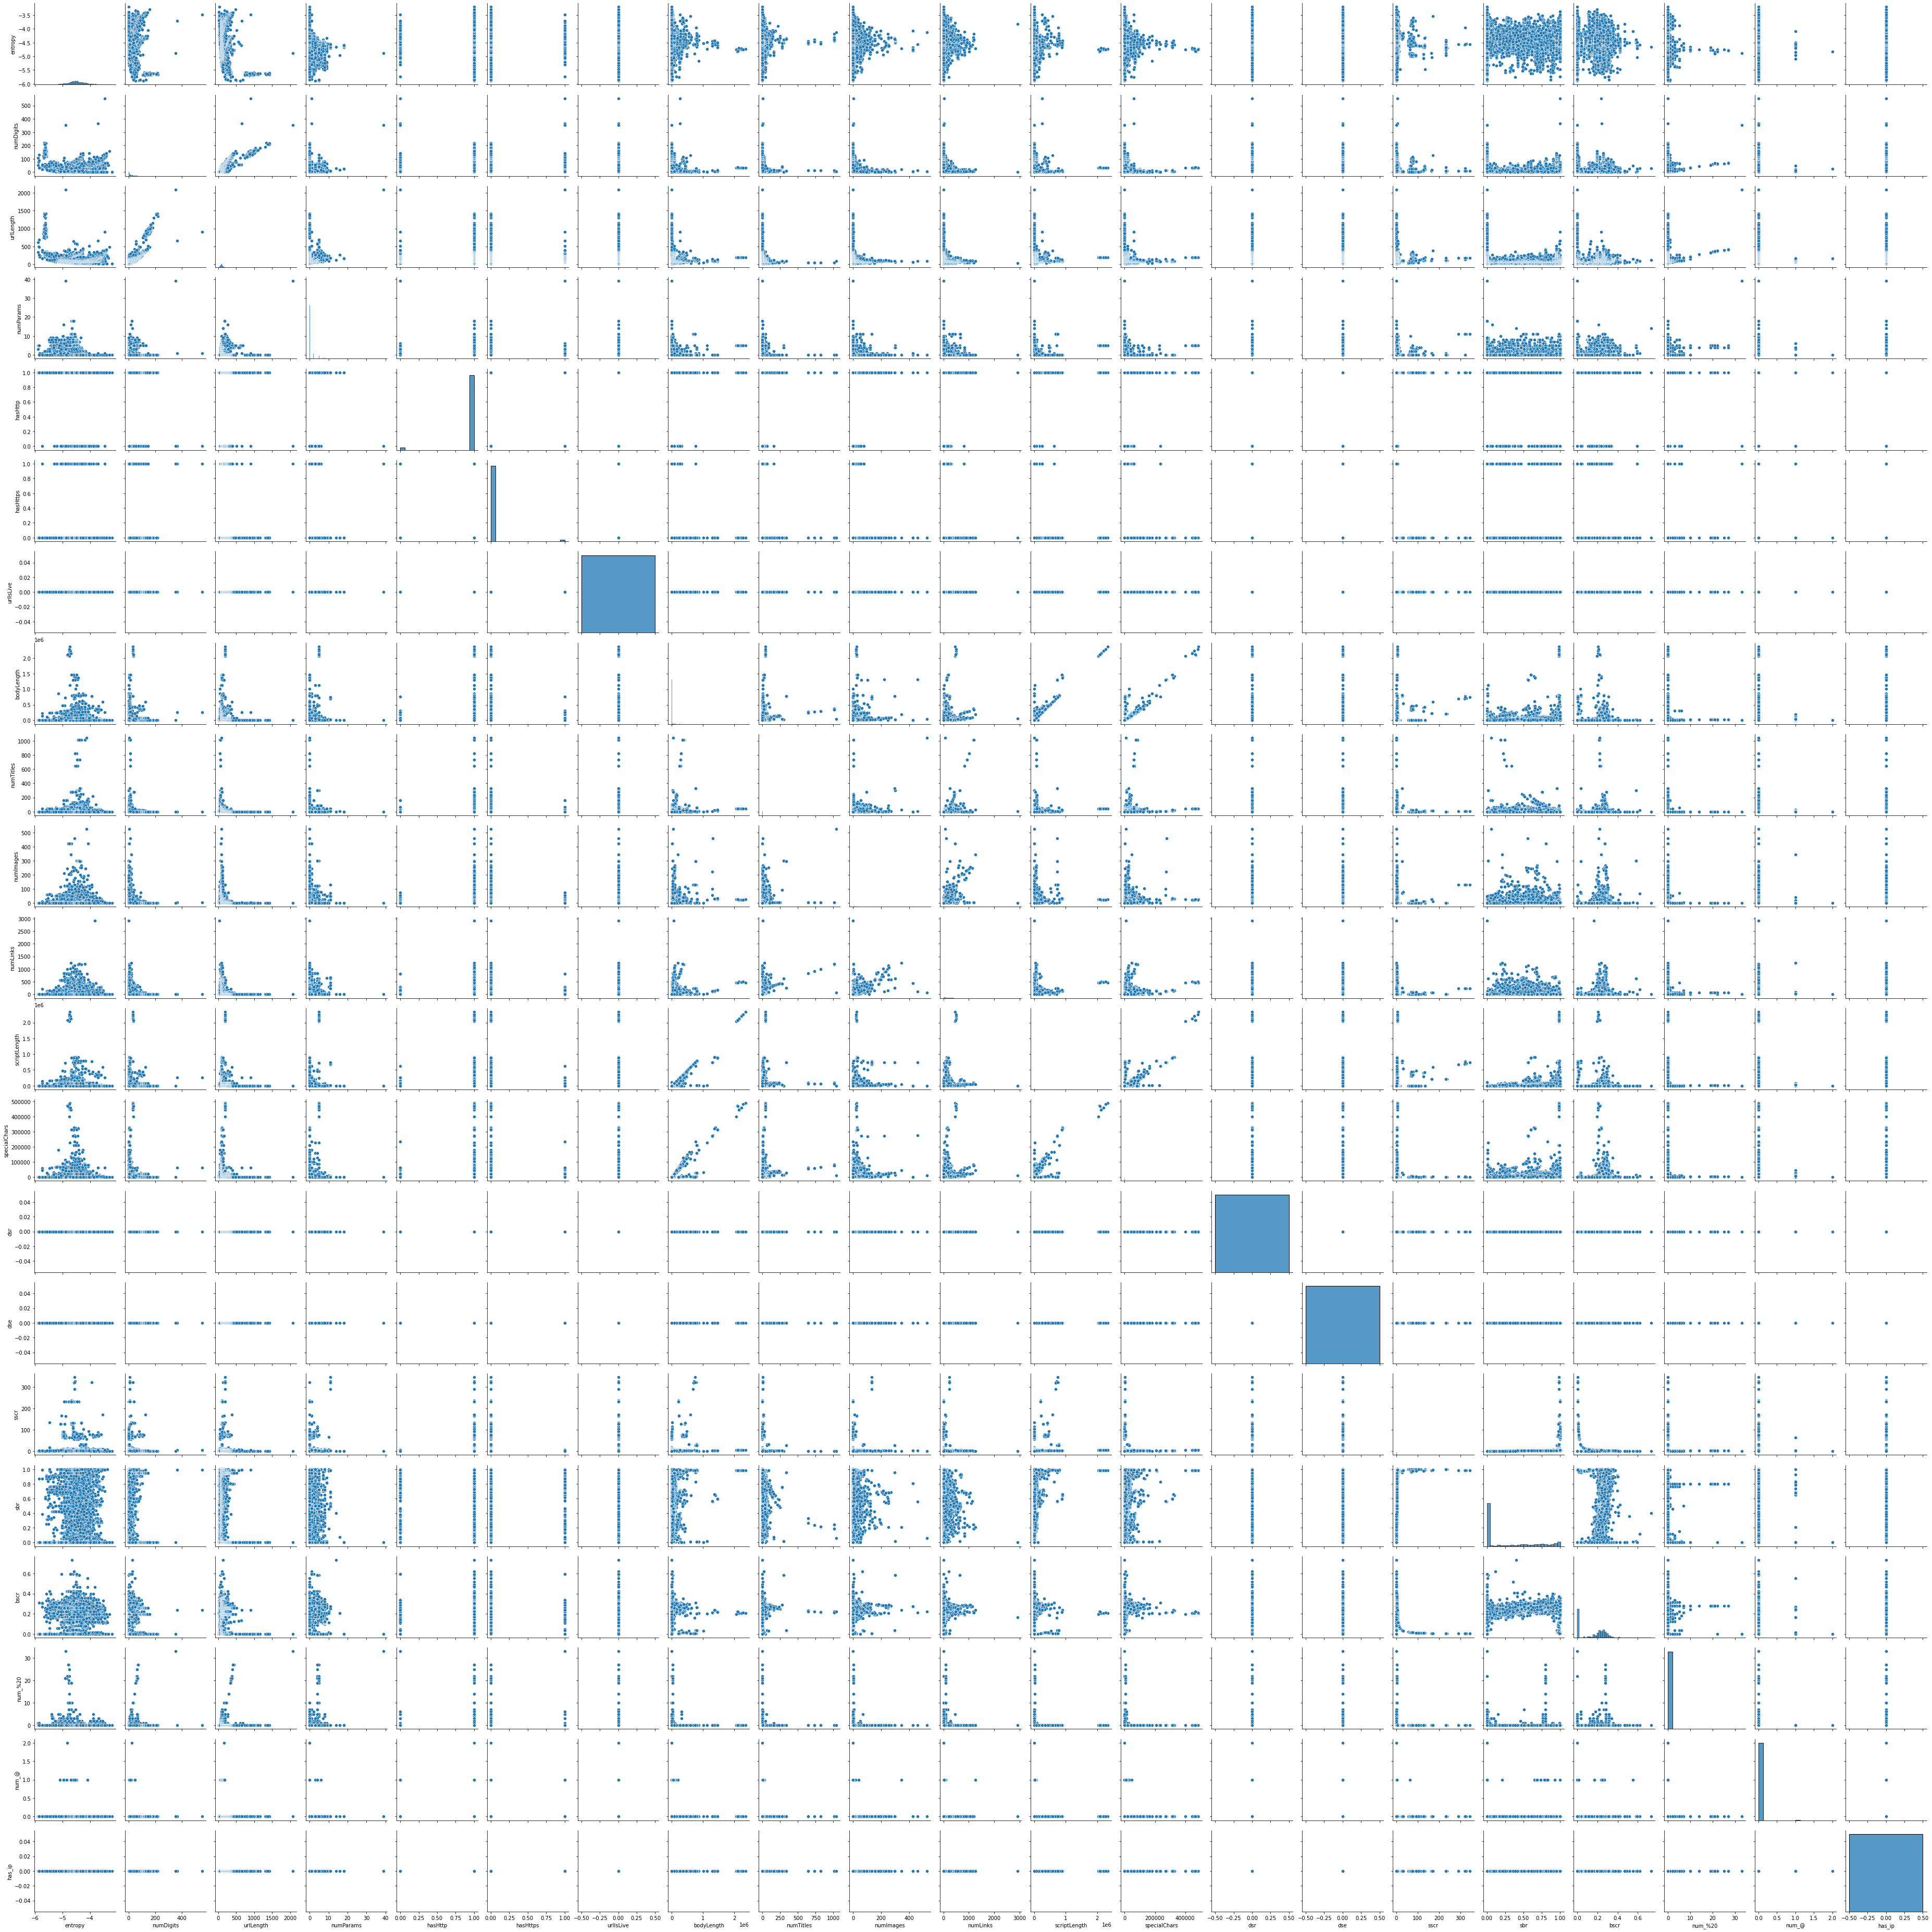

In [27]:
import seaborn as sns
sns.pairplot(df)

Text(0, 0.5, 'URL Type')

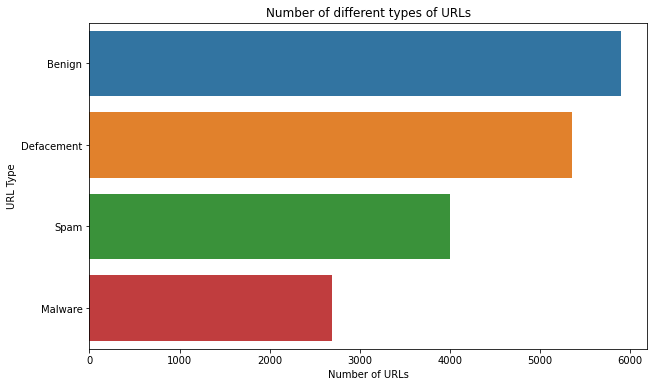

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(x=df["File"].value_counts(),y=df["File"].value_counts().index)
plt.title("Number of different types of URLs")
plt.xlabel("Number of URLs")
plt.ylabel("URL Type")

In [29]:
df.numDigits.describe()

count    17951.000000
mean        13.295917
std         19.897364
min          0.000000
25%          3.000000
50%          7.000000
75%         17.000000
max        554.000000
Name: numDigits, dtype: float64

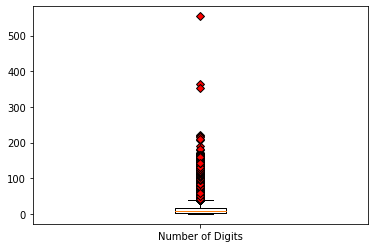

In [30]:
data = df[['numDigits']]
# create outlier point shape
red_diamond = dict(markerfacecolor='r', marker='D')
# generate subplots
fig, ax = plt.subplots()
# make the boxplot
plt.boxplot(data.values, labels=['Number of Digits'], flierprops=red_diamond);

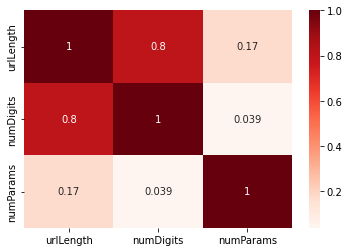

In [31]:

# Creating a matrix using age, salry, balance as rows and columns
df[['urlLength','numDigits','numParams']].corr()

#plot the correlation matrix of salary, balance and age in data dataframe.
sns.heatmap(df[['urlLength','numDigits','numParams']].corr(), annot=True, cmap = 'Reds')
plt.show()

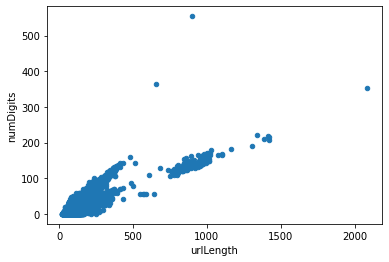

In [32]:
#plot the scatter plot of balance and age variable in data
df.plot.scatter(x="urlLength",y="numDigits")
plt.show()

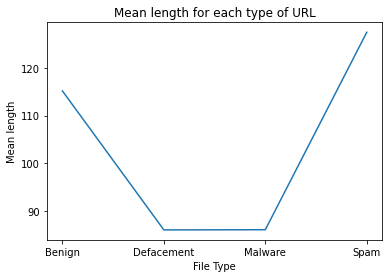

In [33]:
# mean length of url based on URL type
length_by_File_type = df.groupby('File').urlLength.mean()
x = length_by_File_type.index.tolist()
y = length_by_File_type.values.tolist()
# set title
plt.title('Mean length for each type of URL')
# set axis labels
plt.xlabel('File Type')
plt.ylabel('Mean length')
# set xticks 
plt.xticks(labels=x, ticks=np.arange(len(x)))
plt.plot(x, y)

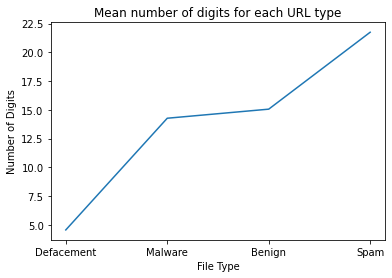

In [35]:
digits_by_File_type = df.groupby('File').numDigits.mean()
digits_by_File_type.sort_values(inplace=True)
x = digits_by_File_type.index.tolist()
y = digits_by_File_type.values.tolist()
# set axis labels
plt.xlabel('File Type')
plt.ylabel('Number of Digits')
# set title
plt.title('Mean number of digits for each URL type')
# set xticks 
plt.xticks(labels=x, ticks=np.arange(len(x)))
plt.plot(x, y)

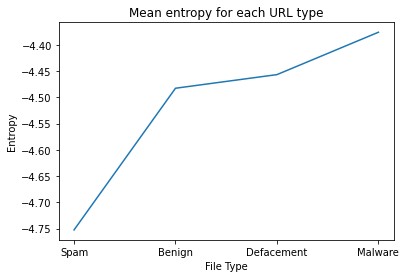

In [36]:
entropy_by_File_type = df.groupby('File').entropy.mean()
entropy_by_File_type.sort_values(inplace=True)
x = entropy_by_File_type.index.tolist()
y = entropy_by_File_type.values.tolist()
# set axis labels
plt.xlabel('File Type')
plt.ylabel('Entropy')
# set title
plt.title('Mean entropy for each URL type')
# set xticks 
plt.xticks(labels=x, ticks=np.arange(len(x)))
plt.plot(x, y)

In [37]:
df['hasHttp'].value_counts()

True     17376
False      575
Name: hasHttp, dtype: int64

In [38]:
df['hasHttps'].value_counts()

False    17582
True       369
Name: hasHttps, dtype: int64

In [39]:
http = df.groupby('File').hasHttp.sum()
https = df.groupby('File').hasHttps.sum()

In [40]:
http

File
Benign        5579
Defacement    5360
Malware       2436
Spam          4001
Name: hasHttp, dtype: int64

In [41]:
https

File
Benign        325
Defacement      0
Malware        44
Spam            0
Name: hasHttps, dtype: int64

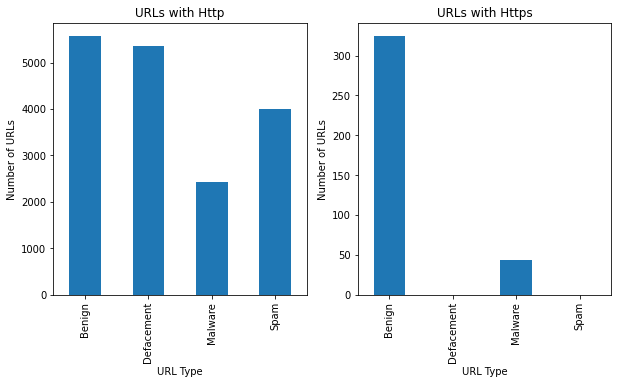

In [42]:
fig = plt.figure()
plt.subplot(1,2,1)
http.plot(kind='bar', title='URLs with Http', ylabel='Number of URLs',
         xlabel='URL Type', figsize=(10, 5))
plt.subplot(1,2,2)
https.plot(kind='bar', title='URLs with Https', ylabel='Number of URLs',
         xlabel='URL Type', figsize=(10, 5))
plt.show()

In [20]:
pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn: started
    Running setup.py install for sklearn: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 2.8.0 requires astropy>=4.0, which is not installed.
pandas-profiling 2.8.0 requires confuse>=1.0.0, which is not installed.
pandas-profiling 2.8.0 requires htmlmin>=0.1.12, which is not installed.
pandas-profiling 2.8.0 requires ipywidgets>=7.5.1, which is not installed.
pandas-profiling 2.8.0 requires missingno>=0.4.2, which is not installed.
pandas-profiling 2.8.0 requires phik>=0.9.10, which is not installed.
pandas-profiling 2.8.0 requires tangled-up-in-unicode>=0.0.6, which is not installed.
pandas-profiling 2.8.0 requires tqdm>=4.43.0, which is not installed.
pandas-profiling 2.8.0 requires visions[type_image_path]==0.4.4, which is not installed.
You should consider upgrading via the 'C:\Users\ADI\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [21]:
pip install keras

You should consider upgrading via the 'C:\Users\ADI\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [22]:
pip install tensorflow

  Using cached wrapt-1.12.1-py3-none-any.whl
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached rsa-4.7.2-py3-none-any.whl (34 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
Using legacy 'setup.py install' for clang, since package 'wheel' is not installed.
Using legacy 'setup.py install' for termcolor, since package 'wheel' is not installed

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\adi\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\~umpy\\.libs\\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'C:\Users\ADI\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [13]:
pip install tensorflow

  Using cached tensorflow-2.6.0-cp37-cp37m-win_amd64.whl (423.2 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached clang-5.0.tar.gz (30 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached h5py-3.1.0-cp37-cp37m-win_amd64.whl (2.7 MB)
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
  Using cached grpcio-1.41.0-cp37-cp37m-win_amd64.whl (3.1 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached wrapt-1.12.1-py3-none-any.whl
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached cached_property-1.5.2-py2.py3-none-any.whl (7.6 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl 

You should consider upgrading via the 'C:\Users\ADI\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [43]:
import tensorflow as ts

In [44]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.decomposition import PCA
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
from keras import backend as K
import pickle
import os
import pandas as pd
import tensorflow as ts
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
from keras import backend as K
import pickle

In [ ]:
'''
le=LabelEncoder()
df["hasHttp"]=le.fit_transform(df["hasHttp"])
df["hasHttps"]=le.fit_transform(df["hasHttps"])
df["urlIsLive"]=le.fit_transform(df["urlIsLive"])
'''

'\nle=LabelEncoder()\ndf["hasHttp"]=le.fit_transform(df["hasHttp"])\ndf["hasHttps"]=le.fit_transform(df["hasHttps"])\ndf["urlIsLive"]=le.fit_transform(df["urlIsLive"])\n'

In [45]:
df.replace(True,1,inplace = True)    
df.replace(False,0,inplace = True)

In [46]:
df.head()

entropy  numDigits  urlLength  numParams  hasHttp  hasHttps  urlIsLive  \
0 -4.280120          0         43          0        1         0          0   
1 -4.254641          1         58          0        1         0          0   
2 -4.419185          9        148          0        1         0          0   
3 -4.010013          1         44          0        1         0          0   
4 -4.673954          4         98          4        1         0          0   

   bodyLength  numTitles  numImages  ...  \
0          52          0          0  ...   
1           0          0          0  ...   
2           0          0          0  ...   
3         125          1          0  ...   
4       11295          6          4  ...   

                                                 ext  dsr  dse      sscr  \
0                                               html    0    0  0.000000   
1                                                  1    0    0  0.000000   
2                                                php    0    0  0.000000   
3                                                  1    0    0  0.000000   
4  php?option=com_content&view=category&layout=bl...    0    0  1.465494   

        sbr      bscr  num_%20  num_@  has_ip        File  
0  0.000000  0.134615        0      0       0  Defacement  
1  0.000000  0.000000        0      0       0  Defacement  
2  0.000000  0.000000        0      0       0  Defacement  
3  0.000000  0.184000        0      0       0  Defacement  
4  0.383533  0.261709        0      0       0  Defacement  

[5 rows x 23 columns]

In [47]:
y = df["File"]

In [48]:
encoder = LabelEncoder()
encoder.fit(y)
Y = encoder.transform(y)

In [49]:
Y.size

17951

In [50]:
df = df.drop(columns = "File")

In [51]:
df.dtypes

entropy         float64
numDigits         int64
urlLength         int64
numParams         int64
hasHttp           int64
hasHttps          int64
urlIsLive         int64
bodyLength        int64
numTitles         int64
numImages         int64
numLinks          int64
scriptLength      int64
specialChars      int64
ext              object
dsr               int64
dse               int64
sscr            float64
sbr             float64
bscr            float64
num_%20           int64
num_@             int64
has_ip            int64
dtype: object

In [52]:
df = df.drop(columns = "ext")

In [53]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(df)
X = pd.DataFrame(X)

In [54]:
import os
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from keras.utils import np_utils
from keras import backend as K
import pickle

In [55]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from keras.layers import LeakyReLU
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
input_dim = len(df.columns)
model = Sequential()
model.add(Dense(256, input_dim = input_dim , activation = lrelu))
model.add(Dense(128, activation = lrelu))
model.add(Dense(64, activation = lrelu))
model.add(Dense(32, activation = lrelu))
model.add(Dense(16, activation = lrelu))
model.add(Dense(4, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [57]:
model.fit(X_train,np_utils.to_categorical(y_train),epochs = 70,validation_split=0.3, batch_size = 128)

Epoch 1/70
69/69 [==============================] - 1s 8ms/step - loss: 1.2734 - accuracy: 0.4204 - val_loss: 1.1644 - val_accuracy: 0.5069
Epoch 2/70
69/69 [==============================] - 0s 4ms/step - loss: 1.0703 - accuracy: 0.5742 - val_loss: 1.0360 - val_accuracy: 0.5971
Epoch 3/70
69/69 [==============================] - 0s 4ms/step - loss: 0.9630 - accuracy: 0.6285 - val_loss: 0.9201 - val_accuracy: 0.6464
Epoch 4/70
69/69 [==============================] - 0s 4ms/step - loss: 0.8682 - accuracy: 0.6712 - val_loss: 0.8149 - val_accuracy: 0.6918
Epoch 5/70
69/69 [==============================] - 0s 4ms/step - loss: 0.8059 - accuracy: 0.6969 - val_loss: 0.7969 - val_accuracy: 0.7159
Epoch 6/70
69/69 [==============================] - 0s 4ms/step - loss: 0.7549 - accuracy: 0.7251 - val_loss: 0.7339 - val_accuracy: 0.7273
Epoch 7/70
69/69 [==============================] - 0s 4ms/step - loss: 0.7132 - accuracy: 0.7355 - val_loss: 0.7213 - val_accuracy: 0.7342
Epoch 8/70
69/69 [==

In [58]:
y_pred = model.predict(X_test)

In [59]:
predicted = np.argmax(y_pred, axis=1)

In [60]:
from sklearn.metrics import classification_report
print(accuracy_score(y_test,predicted))

0.8665057556628296


In [61]:
target_names = ['Benign','Defacement','Malware','Spam']
print(classification_report(y_test, predicted, target_names=target_names))

              precision    recall  f1-score   support

      Benign       0.91      0.90      0.90      1747
  Defacement       0.85      0.83      0.84      1600
     Malware       0.75      0.83      0.79       808
        Spam       0.91      0.90      0.91      1231

    accuracy                           0.87      5386
   macro avg       0.86      0.86      0.86      5386
weighted avg       0.87      0.87      0.87      5386



In [62]:
pip install fastai

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\ADI\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [63]:
from fastai.tabular import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
from sklearn.utils import shuffle
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.utils.multiclass import unique_labels

In [64]:
def runExperiments(X_train, Y_train):
    random_seed = 100
    scoring = 'accuracy'
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='auto')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('NB', GaussianNB()))
    models.append(('RF', RandomForestClassifier(n_estimators=10)))

    # evaluate each model in turn using 10-fold cross-validation
    results = []
    classifiers = []
    accuracies = []
    for classifier, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=None)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        accuracies.append((cv_results.mean(), classifier))
        results.append(cv_results)
        classifiers.append(classifier)
        msg = "%s: %f (%f)" % (classifier, cv_results.mean(), cv_results.std())
        print(msg)
    return results, accuracies, classifiers

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
results, accuracies, classifiers = runExperiments(X_train, y_train)

LR: 0.570315 (0.008922)
LDA: 0.582651 (0.009080)
NB: 0.417031 (0.007608)
RF: 0.914845 (0.008305)


In [66]:
def testBestModel(model, X_test, Y_test):
    # make predictions on validation dataset
    Y_predictions = rf.predict(X_test)
    print("Accuracy = {:.2f}".format(accuracy_score(Y_test, Y_predictions)))
    print('Confusion Matrix:')
    print(confusion_matrix(Y_test, Y_predictions))
    print('Classification Report:')
    print(classification_report(Y_test, Y_predictions))
    return Y_predictions

In [67]:
# train the best model and find the validation accuracy
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
Y_predictions = testBestModel(rf, X_test, y_test)

Accuracy = 0.92
Confusion Matrix:
[[1685   38   25    2]
 [  62 1478   54   29]
 [  37   78  657    8]
 [  15   69   12 1137]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1750
           1       0.89      0.91      0.90      1623
           2       0.88      0.84      0.86       780
           3       0.97      0.92      0.94      1233

    accuracy                           0.92      5386
   macro avg       0.92      0.91      0.91      5386
weighted avg       0.92      0.92      0.92      5386



In [68]:
#os.chdir("../")
model.save("Model_v2.h5")
np.save('lblenc_v1.npy', encoder.classes_)
scalerfile = 'scaler_v1.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))